# Movie reviews - Final Assignment Iteration #3
### Heew Kim | Nov 2020

Third iteration of the final assignment 1 using the movie review dataset based on feature modification combined with regularized ridge regression model using further alpha optimization with more trade-offs between train/test. 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

## MODIFIED feature building and extraction functions 

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data_modified(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix; added uni- & bigrams; deleted stopwords
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 16, ngram_range = (1,2), alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

## MODIFIED training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do):
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data_modified(fn='/Users/heewoong.kim/Documents/GitHub/ml/ProjectDataset/moviereviews_train.tsv', my_random_seed=99)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 65536)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9
5

## Fit (and tune) the Ridge Regression Models

In [5]:
from sklearn import linear_model

#set alphas and arrays
alphas = [8.5e+4, 9e+4, 9.25e+4, 9.5e+4, 9.75e+4, 1e+5, 1.03e+5, 1.05e+5, 1.08e+5, 1.1e+5]
rdg={}
rdg_train={}
rdg_test={}

#loop for rdg model fitting/tuning for alphas
for i in range(10):
    rdg[i] = linear_model.RidgeClassifier(alpha=alphas[i])
    rdg[i].fit(X_train, y_train)
    #train set performance
    rdg_train[i] = BinaryClassificationPerformance(rdg[i].predict(X_train), y_train, ('tr'+str(alphas[i])))
    rdg_train[i].compute_measures()
    #test set performance
    rdg_test[i] = BinaryClassificationPerformance(rdg[i].predict(X_test), y_test, ('ts'+str(alphas[i])))
    rdg_test[i].compute_measures()


In [6]:
#print performance measures 

for i in range(10):
    print(rdg_train[i].performance_measures)
    print(rdg_test[i].performance_measures)
    print('* * * * *')


{'Pos': 9988, 'Neg': 10012, 'TP': 9973, 'TN': 10004, 'FP': 8, 'FN': 15, 'Accuracy': 0.99885, 'Precision': 0.9991984771065023, 'Recall': 0.9984981978374049, 'desc': 'tr85000.0'}
{'Pos': 2512, 'Neg': 2488, 'TP': 2239, 'TN': 2166, 'FP': 322, 'FN': 273, 'Accuracy': 0.881, 'Precision': 0.8742678641155799, 'Recall': 0.8913216560509554, 'desc': 'ts85000.0'}
* * * * *
{'Pos': 9988, 'Neg': 10012, 'TP': 9969, 'TN': 10004, 'FP': 8, 'FN': 19, 'Accuracy': 0.99865, 'Precision': 0.999198155758244, 'Recall': 0.9980977172607128, 'desc': 'tr90000.0'}
{'Pos': 2512, 'Neg': 2488, 'TP': 2241, 'TN': 2167, 'FP': 321, 'FN': 271, 'Accuracy': 0.8816, 'Precision': 0.8747072599531616, 'Recall': 0.8921178343949044, 'desc': 'ts90000.0'}
* * * * *
{'Pos': 9988, 'Neg': 10012, 'TP': 9967, 'TN': 10003, 'FP': 9, 'FN': 21, 'Accuracy': 0.9985, 'Precision': 0.9990978348035284, 'Recall': 0.9978974769723669, 'desc': 'tr92500.0'}
{'Pos': 2512, 'Neg': 2488, 'TP': 2243, 'TN': 2168, 'FP': 320, 'FN': 269, 'Accuracy': 0.8822, 'Prec

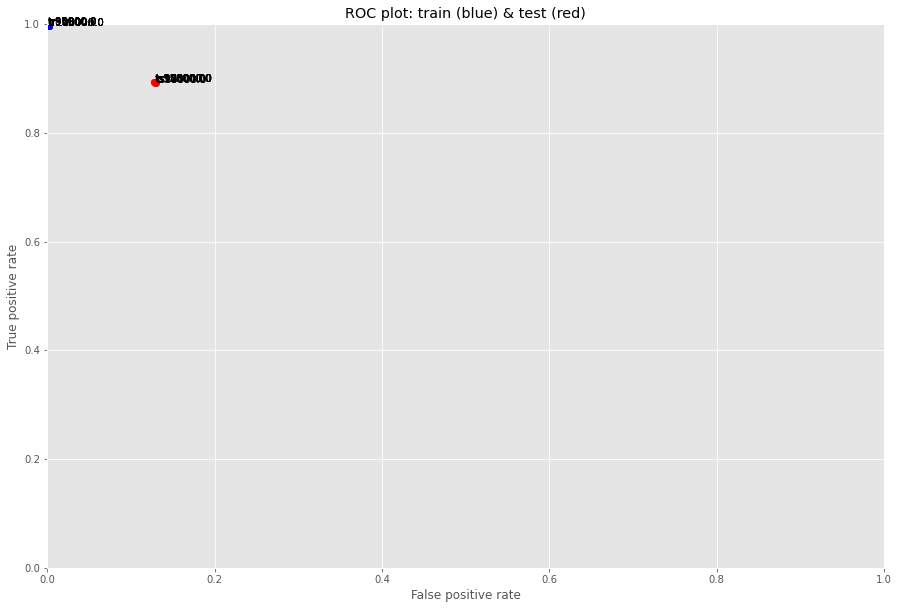

In [12]:
#ROC plot original range
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
for i in range(10):
    plt.plot(rdg_train[i].performance_measures['FP'] / rdg_train[i].performance_measures['Neg'],
             rdg_train[i].performance_measures['TP'] / rdg_train[i].performance_measures['Pos'], 'bo')
    plt.text(rdg_train[i].performance_measures['FP'] / rdg_train[i].performance_measures['Neg'],
             rdg_train[i].performance_measures['TP'] / rdg_train[i].performance_measures['Pos'], rdg_train[i].desc)
    plt.plot(rdg_test[i].performance_measures['FP'] / rdg_test[i].performance_measures['Neg'],
             rdg_test[i].performance_measures['TP'] / rdg_test[i].performance_measures['Pos'], 'ro')
    plt.text(rdg_test[i].performance_measures['FP'] / rdg_test[i].performance_measures['Neg']+0.001,
             rdg_test[i].performance_measures['TP'] / rdg_test[i].performance_measures['Pos'], rdg_test[i].desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train (blue) & test (red)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

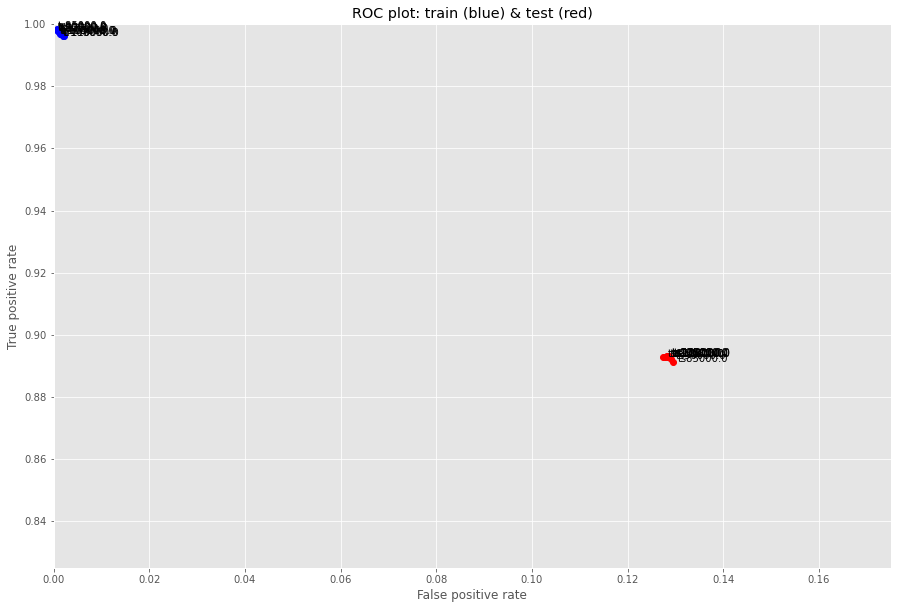

In [8]:
#ROC plot modified range

plt.figure(figsize=(15,10))

for i in range(10):
    plt.plot(rdg_train[i].performance_measures['FP'] / rdg_train[i].performance_measures['Neg'],
             rdg_train[i].performance_measures['TP'] / rdg_train[i].performance_measures['Pos'], 'bo')
    plt.text(rdg_train[i].performance_measures['FP'] / rdg_train[i].performance_measures['Neg'],
             rdg_train[i].performance_measures['TP'] / rdg_train[i].performance_measures['Pos'], rdg_train[i].desc)
    plt.plot(rdg_test[i].performance_measures['FP'] / rdg_test[i].performance_measures['Neg'],
             rdg_test[i].performance_measures['TP'] / rdg_test[i].performance_measures['Pos'], 'ro')
    plt.text(rdg_test[i].performance_measures['FP'] / rdg_test[i].performance_measures['Neg']+0.001,
             rdg_test[i].performance_measures['TP'] / rdg_test[i].performance_measures['Pos'], rdg_test[i].desc)
plt.axis([0, .175, .825, 1])
plt.title('ROC plot: train (blue) & test (red)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


In [9]:
rdg_train_df = []
rdg_test_df = []

for i in range(10):
    rdg_train_df.append(rdg_train[i].performance_measures['Accuracy'])
    rdg_test_df.append(rdg_test[i].performance_measures['Accuracy'])

rdg_df = pd.concat([pd.DataFrame(alphas), pd.DataFrame(rdg_train_df), pd.DataFrame(rdg_test_df)], axis=1)
rdg_df.columns = ['alphas', 'train_accuracy', 'test_accuracy']

rdg_df


,alphas,train_accuracy,test_accuracy
0,85000.0,0.99885,0.8810
1,90000.0,0.99865,0.8816
2,92500.0,0.99850,0.8822
3,95000.0,0.99835,0.8826
4,97500.0,0.99810,0.8826
5,100000.0,0.99785,0.8824
6,103000.0,0.99765,0.8822
7,105000.0,0.99750,0.8826
8,108000.0,0.99715,0.8824
9,110000.0,0.99700,0.8828


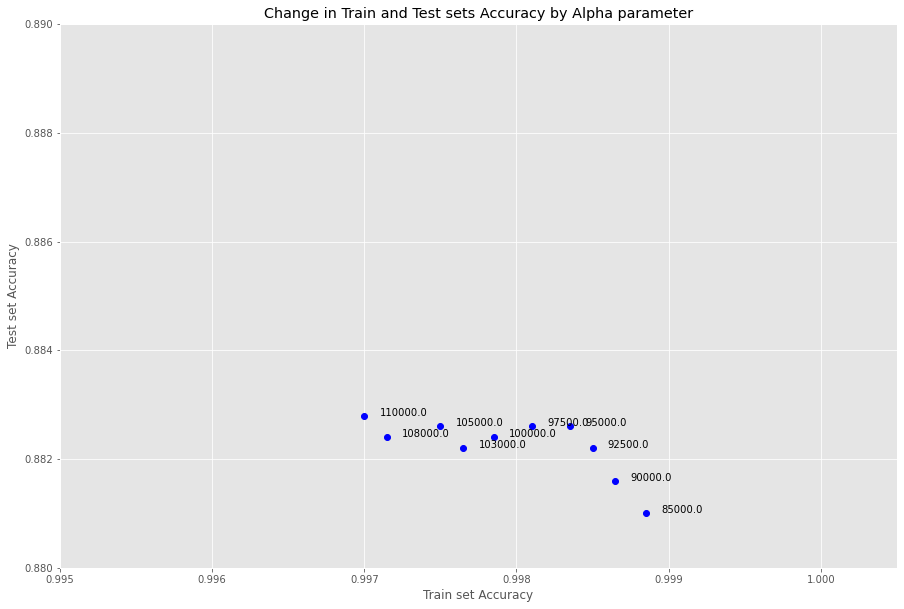

In [11]:
plt.figure(figsize=(15,10))

for i in range(10):
    plt.plot(rdg_train[i].performance_measures['Accuracy'], rdg_test[i].performance_measures['Accuracy'], 'bo')
    plt.text(rdg_train[i].performance_measures['Accuracy']+1e-4, rdg_test[i].performance_measures['Accuracy'], alphas[i])
    
plt.axis([.995, 1.0005, .88, .89])
plt.title('Change in Train and Test sets Accuracy by Alpha parameter')
plt.xlabel('Train set Accuracy')
plt.ylabel('Test set Accuracy')
plt.show()



## Fit the optimal Ridge Regression Models with alpha 9.5e+4

In [13]:
from sklearn import linear_model

# ridge regression based on alpha set at 7e+4 based on previous model tuning
rdg = linear_model.RidgeClassifier(alpha=9.5e+4)
rdg.fit(X_train, y_train)
#train set performance
rdg_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'train')
rdg_train.compute_measures()
#test set performance
rdg_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'test')
rdg_test.compute_measures()

print(rdg_train.performance_measures)
print(rdg_test.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9965, 'TN': 10002, 'FP': 10, 'FN': 23, 'Accuracy': 0.99835, 'Precision': 0.9989974937343359, 'Recall': 0.9976972366840208, 'desc': 'train'}
{'Pos': 2512, 'Neg': 2488, 'TP': 2243, 'TN': 2170, 'FP': 318, 'FN': 269, 'Accuracy': 0.8826, 'Precision': 0.8758297540023429, 'Recall': 0.8929140127388535, 'desc': 'test'}


## Reviews predictions based on choosen model

In [14]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [15]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:


---

# <span style="color:red">SUBMISSION</span>

---

In [16]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data_modified(fn='/Users/heewoong.kim/Documents/GitHub/ml/ProjectDataset/moviereviews_test.tsv', my_random_seed=99, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 65536)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size 

In [17]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49956


In [18]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [19]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [20]:
my_submission.shape

(25000, 2)

In [21]:
# export submission file as csv
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/heewoong.kim/Documents/GitHub/ml/final_assignment_1/moviereviews_submission3.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation